In [1]:
%reload_ext autoreload
%autoreload 2
from importlib import reload

import logging
import warnings
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import h5py
import tqdm.notebook as tqdm

import kalepy as kale
import kalepy.utils
import kalepy.plot

import holodeck as holo
from holodeck import cosmo, utils, plot
from holodeck.constants import MSOL, PC, YR, MPC, GYR, SPLC

mpl.style.use('default')   # avoid dark backgrounds from dark theme vscode

log = holo.log
log.setLevel(logging.WARNING)

In [2]:
pop = holo.population.Pop_Illustris()
fixed = holo.hardening.Fixed_Time.from_pop(pop, 2.0 * GYR)
evo = holo.evolution.Evolution(pop, fixed)
evo.evolve()

10:53:37 WARNING : class `Fixed_Time` has been deprecated!  Please use `Fixed_Time_2PL` with new parametrization! [hardening.py:__init__]


In [21]:
fobs, fobs_edges = holo.utils.pta_freqs(dur=1.0*YR, num=10)
print(fobs*1e9)
gwb = holo.gravwaves.GW_Discrete(evo, fobs)
gwb.emit()

[ 31.68808781  63.37617563  95.06426344 126.75235126 158.44043907
 190.12852688 221.8166147  253.50470251 285.19279033 316.88087814]
10:59:49 ERROR : `GW_Discrete` will not work properly with unevenly sampled frequency (log-space)! [gravwaves.py:__init__]
NoneType: None


GW frequencies:   0%|          | 0/10 [00:00<?, ?it/s]

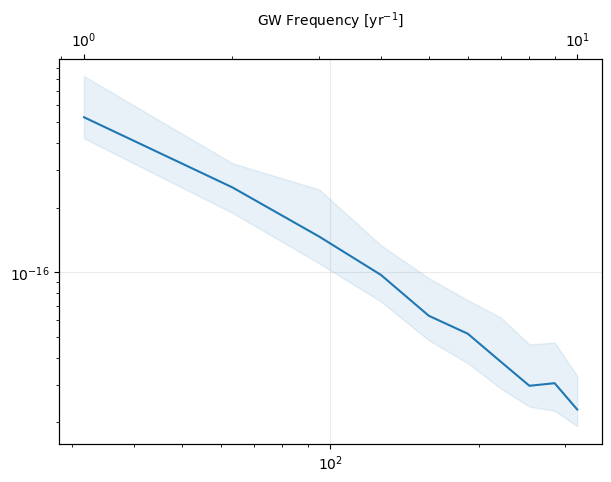

In [22]:
fig, ax = plot.figax()
ax.grid(True, alpha=0.25)
xx = fobs*1e9
med = np.median(gwb.both, axis=-1)
conf = np.percentile(gwb.both, [25, 75], axis=-1)
cc, = ax.plot(xx, med)
ax.fill_between(xx, *conf, color=cc.get_color(), alpha=0.1)
plot._twin_yr(ax)
plt.show()

In [42]:
fobs_orb_edges = fobs_edges / 2.0
names, samples, vals, weights = evo.sample_universe(fobs_orb_edges)

In [47]:
samples[3]

array([1.52536444e-08, 3.20327896e-08, 1.57024714e-08, ...,
       1.75546182e-08, 1.55448113e-08, 1.74970033e-08])

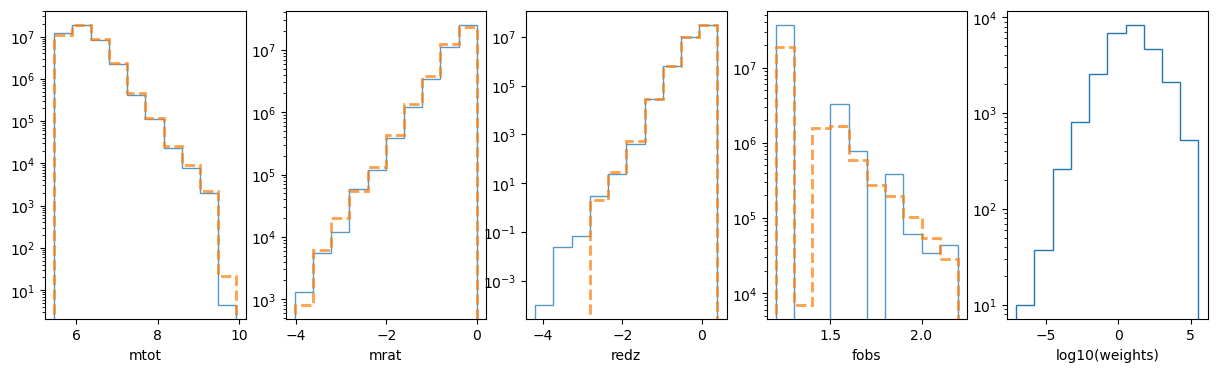

In [46]:
fig, axes = plt.subplots(figsize=[15, 4], ncols=5)
units = [MSOL, 1.0, 1.0, 1e-9, 1.0]
for ii, ax in enumerate(axes):
    if ii < 4:
        xx = vals[ii] / units[ii]
        xx = np.log10(xx)
        nums, bins, patches = ax.hist(xx, weights=weights, histtype='step', alpha=0.75)
        xx = np.log10(samples[ii] / units[ii])
        ax.hist(xx, bins=bins, histtype='step', ls='--', lw=2.0, alpha=0.75)
        ax.set(yscale='log', xlabel=names[ii])
    else:
        ax.hist(np.log10(weights), histtype='step')
        ax.set(xscale='linear', yscale='log', xlabel='log10(weights)')
                
plt.show()

In [25]:
names, samples.shape, vals.shape, weights.shape

(['mtot', 'mrat', 'redz', 'fobs'], (4, 41790993), (4, 26108), (26108,))

In [ ]:
nn, ss = evo._sample_universe(fobs)
print(f"{ss.shape[1]:.4e}")

In [ ]:
hs, fo = holo.sam._strains_from_samples(samples)

nloud = 5
colors = plot._get_cmap('plasma')(np.linspace(0.05, 0.95, nloud))# print(colors)

fig, ax = plot.figax(figsize=[12, 8], xlabel='Frequency [yr$^{-1}$]', ylabel='c-Strain')
for ii in utils.tqdm(range(fobs.size-1)):
    # if ii < 10 or ii > 16:
    #     continue
    
    fextr = [fobs[ii+jj] for jj in range(2)]
    fextr = np.asarray(fextr)
    cycles = 1.0 / np.diff(np.log(fextr))[0]

    idx = (fextr[0] <= fo) & (fo < fextr[1])
    hs_bin = hs[idx]
    fo_bin = fo[idx]    

    tot = np.sqrt(np.sum(cycles * hs_bin**2))
    ax.plot(fextr*YR, tot * np.ones_like(fextr), 'k--')

    idx = np.argsort(hs_bin)[::-1]
    
    for jj, cc in enumerate(colors):
        if jj > len(idx):
            break
        hi = idx[jj]
        lo = idx[jj+1:]
        gw_hi = np.sqrt(np.sum(cycles * hs_bin[hi]**2))
        gw_lo = np.sqrt(np.sum(cycles * hs_bin[lo]**2))

        fave = np.average(fo_bin[hi], weights=hs_bin[hi])
        ax.plot(fextr*YR, gw_lo * np.ones_like(fextr), color=cc, lw=0.5)
        ax.scatter(fave*YR, gw_hi, marker='.', color=cc, alpha=0.5)

plt.show()